In [ ]:
import pandas as pd

export_combined_data_path = "./combined.csv"

data_result_0_path = "C:/Dev/picoVideo/vrtv/SavedTrainingDataset/20230813_merged/0/20230816_8_8_0_0.csv"
data_result_1_path = "C:/Dev/picoVideo/vrtv/SavedTrainingDataset/20230813_merged/1/20230816_8_8_0_1.csv"
data_result_2_path = "C:/Dev/picoVideo/vrtv/SavedTrainingDataset/20230813_merged/2/20230816_8_8_0_2.csv"

# Read data
data_result_0 = pd.read_csv(data_result_0_path, header=None)
data_result_1 = pd.read_csv(data_result_1_path, header=None)
data_result_2 = pd.read_csv(data_result_2_path, header=None)

print(f"data result 0 cnt: {len(data_result_0)}")
print(f"data result 1 cnt: {len(data_result_1)}")
print(f"data result 2 cnt: {len(data_result_2)}")

print(data_result_1.iloc[0:2, :])

data_cnt_per_result = len(data_result_0)
data_result_1 = data_result_1.sample((int)(data_cnt_per_result / 2))
data_result_2 = data_result_2.sample((int)(data_cnt_per_result / 2))

data_all_result = pd.concat([data_result_0, data_result_1, data_result_2], axis=0)
print(f"data with all result cnt: {len(data_all_result)}")

# result为1、2都改为1
data_all_result.loc[data_all_result[68] > 0, 68] = 1

data_all_result.to_csv(export_combined_data_path, header=None, index=None, encoding="utf-8")


In [ ]:
from sklearn.preprocessing import LabelEncoder
import torch

# Read data
data = pd.read_csv(export_combined_data_path, header=None)

print(data.iloc[0:2, :])
X = data.iloc[:, 0:68]
y = data.iloc[:, 68]
print(X.iloc[0:2, :])
print(y)

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [ ]:
import torch.nn as nn

# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(68, 68*3)
        self.relu = nn.ReLU()
        self.output = nn.Linear(68*3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(68, 68)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(68, 68)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(68, 68)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(68, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

In [29]:
import torch.optim as optim
import tqdm
import copy
import numpy as np

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    # loss_fn = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 50  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_values = []
    accuracy_values = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )

        # for start in range(0, len(X_train), batch_size):
        #     X_batch = X_train[start:start+batch_size]
        #     y_batch = y_train[start:start+batch_size]
        #     # forward pass
        #     y_pred = model(X_batch)
        #     loss = loss_fn(y_pred, y_batch)
        #     # backward pass
        #     optimizer.zero_grad()
        #     loss.backward()
        #     # update weights
        #     optimizer.step()

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        loss = loss_fn(y_pred, y_val)
        # running_loss += loss.item()
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        loss_values.append(loss.item())
        accuracy_values.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy

    print("loss_values:")
    print(loss_values)
    print("accuracy_values:")
    print(accuracy_values)
    model.load_state_dict(best_weights)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_values, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.legend()

    plt.show()

    return best_acc

In [13]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

loss_values:
[0.708087682723999, 0.7001901268959045, 0.6950822472572327, 0.6914868354797363, 0.6886431574821472, 0.686238169670105, 0.6841301918029785, 0.6822624206542969, 0.6806288361549377, 0.6791821718215942, 0.6779008507728577, 0.676764190196991, 0.6757587194442749, 0.6748304963111877, 0.6739552617073059, 0.673153817653656, 0.6724314093589783, 0.6717676520347595, 0.6711441278457642, 0.6705780625343323, 0.6700371503829956, 0.6695525050163269, 0.6690881848335266, 0.6686338782310486, 0.6682283282279968, 0.6678546071052551, 0.6674943566322327, 0.6671653389930725, 0.6668440103530884, 0.6665217280387878, 0.6662037968635559, 0.665900707244873, 0.6656159162521362, 0.6653356552124023, 0.6650779843330383, 0.6648627519607544, 0.6646405458450317, 0.6644384860992432, 0.6642456650733948, 0.664090096950531, 0.6639456152915955, 0.6637797355651855, 0.6636210680007935, 0.6634594798088074, 0.6633210182189941, 0.6631817817687988, 0.6630641222000122, 0.6629506945610046, 0.6628420352935791, 0.6627522706

Epoch 299: 100%|██████████| 11/11 [00:00<00:00, 262.59batch/s, acc=1, loss=0.00088]


loss_values:
[0.704389750957489, 0.7025588750839233, 0.7012719511985779, 0.7004027366638184, 0.699756920337677, 0.6992725133895874, 0.698855459690094, 0.6985024809837341, 0.6982250213623047, 0.6979255676269531, 0.6976245641708374, 0.6973398327827454, 0.6970422267913818, 0.6967224478721619, 0.6963810324668884, 0.696071207523346, 0.6956592202186584, 0.6952283978462219, 0.6948423385620117, 0.6943210959434509, 0.6938029527664185, 0.6932420134544373, 0.6928291320800781, 0.6923155188560486, 0.6918846964836121, 0.6916008591651917, 0.6914569735527039, 0.6913939714431763, 0.6912877559661865, 0.6912466883659363, 0.6912463307380676, 0.691189706325531, 0.691365122795105, 0.6915521621704102, 0.6918174624443054, 0.69219970703125, 0.6926190853118896, 0.6933576464653015, 0.6941387057304382, 0.6948812007904053, 0.6956238150596619, 0.6966103911399841, 0.6976211071014404, 0.6986779570579529, 0.6997855305671692, 0.7008839845657349, 0.7020673155784607, 0.7033661007881165, 0.704582154750824, 0.7059504985809

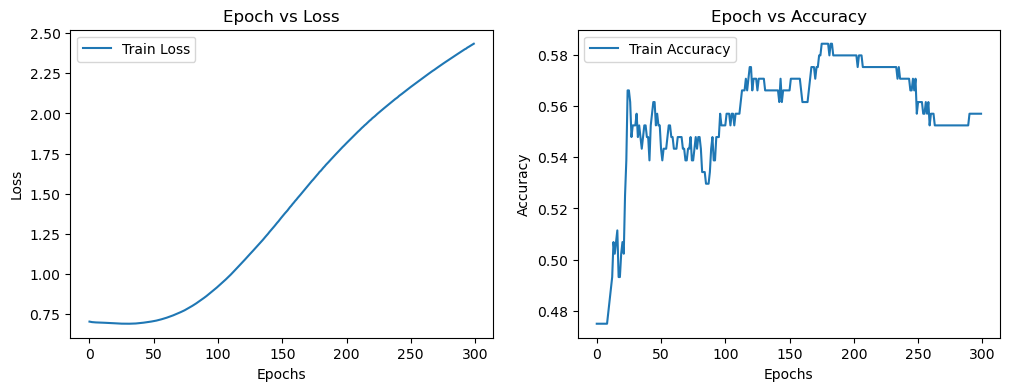

Final model accuracy: 58.45%


In [30]:
from sklearn.model_selection import StratifiedKFold, train_test_split
model = Deep()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")